In [1]:
from fastai.vision.all import *
from facenet_pytorch import MTCNN
from torchvision.transforms.functional import to_pil_image
import pandas as pd
from PIL import Image
import cv2

In [2]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test'])

train_df['file'] = train_df['file'].str.replace('train', 'face_train')
val_df['file'] = val_df['file'].str.replace('val', 'face_val')

In [3]:
print(train_df.head(), '\n')
print('Train shape:', train_df.shape, '\n')


print(val_df.head(), '\n')
print('Val shape:', val_df.shape, '\n')

               file    age  gender        race
0  face_train/1.jpg  50-59    Male  East Asian
1  face_train/2.jpg  30-39  Female      Indian
2  face_train/3.jpg    3-9  Female       Black
3  face_train/4.jpg  20-29  Female      Indian
4  face_train/5.jpg  20-29  Female      Indian 

Train shape: (86744, 4) 

             file    age  gender             race
0  face_val/1.jpg    3-9    Male       East Asian
1  face_val/2.jpg  50-59  Female       East Asian
2  face_val/3.jpg  30-39    Male            White
3  face_val/4.jpg  20-29  Female  Latino_Hispanic
4  face_val/5.jpg  20-29    Male  Southeast Asian 

Val shape: (10954, 4) 



In [4]:
fairface_block = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),  
    get_x=ColReader('file', pref='./Dataset/'),                       
    get_y=ColReader(['age', 'gender', 'race']), 
    splitter=RandomSplitter(seed=42),           
    item_tfms=Resize(224),                      
    batch_tfms=[
        Normalize.from_stats(*imagenet_stats),
        *aug_transforms(
            size=224,
            max_rotate=10,
            min_scale=0.75,
            flip_vert=True,
            max_lighting=0.1,
            max_warp=0.0,
            p_affine=0.75,
            p_lighting=0.75
        )
            
    ] 
)

dls = fairface_block.dataloaders(train_df, bs=64)

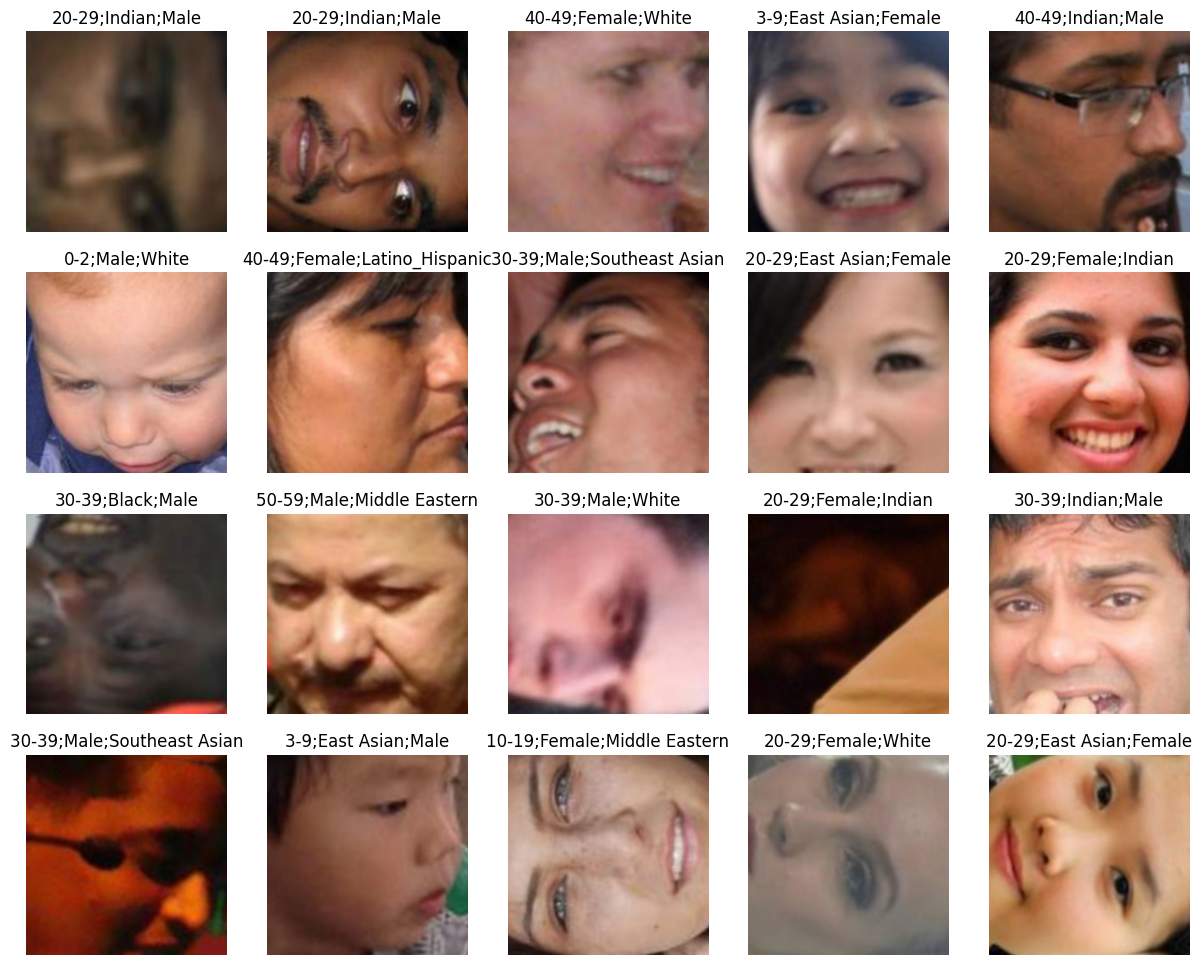

In [5]:
dls.show_batch(max_n=20)

In [6]:
learn = vision_learner(dls, resnet34, metrics=[accuracy_multi])

In [7]:
learn.fine_tune(10, base_lr=1e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.375946,0.344458,0.858450,05:25


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.323513,0.292772,0.876393,07:24
1,0.290568,0.258720,0.888457,07:26
2,0.267204,0.240271,0.895229,07:30
3,0.256214,0.227243,0.899959,07:30
4,0.243973,0.224272,0.901340,07:31
5,0.232229,0.216947,0.903777,07:29
6,0.226270,0.212892,0.906063,07:30
7,0.218943,0.210904,0.906601,07:30
8,0.217444,0.208814,0.907953,07:31
9,0.214594,0.209088,0.907770,07:31


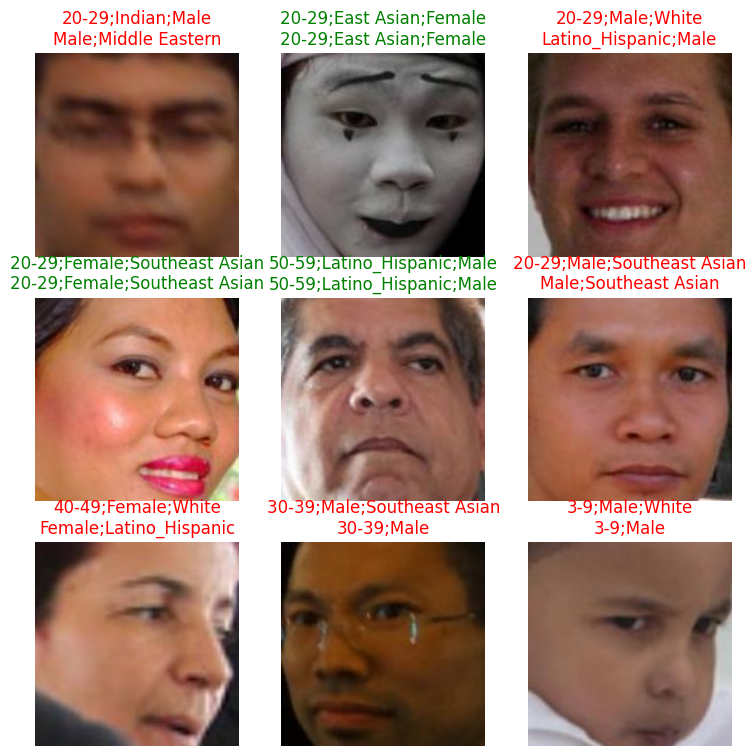

In [20]:
learn.show_results()

In [10]:
mtcnn = MTCNN(
    image_size=224,
    margin=20,
    keep_all=True,
    post_process=True,
    select_largest=False,
    thresholds=[0.6, 0.7, 0.7]  
)

def detect_face_mtcnn(image_path):
    img = Image.open(image_path).convert('RGB')
    faces, _ = mtcnn.detect(img)
    
    if faces is None:
        return img 

    face_images = []
    for (x1, y1, x2, y2) in faces:
        face = img.crop((x1, y1, x2, y2))
        face_images.append(face)
    
    return face_images[0] if face_images else img

age_labels = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern', 'Latino_Hispanic']

img_face = detect_face_mtcnn('./Dataset/face_val/11.jpg')
pred, pred_idx, probs = learn.predict(img_face)

age_probs = probs[:len(age_labels)]
gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
race_probs = probs[len(age_labels) + len(gender_labels):]

print("Age Category Probabilities:")
for label, prob in zip(age_labels, age_probs):
    print(f'{label}: {prob:.4f}')

print("\nGender Category Probabilities:")
for label, prob in zip(gender_labels, gender_probs):
    print(f'{label}: {prob:.4f}')

print("\nRace Category Probabilities:")
for label, prob in zip(race_labels, race_probs):
    print(f'{label}: {prob:.4f}')

Age Category Probabilities:
0-2: 0.0105
3-9: 0.0134
10-19: 0.0388
20-29: 0.0192
30-39: 0.0608
40-49: 0.0946
50-59: 0.1540
60-69: 0.1792
more than 70: 0.0127

Gender Category Probabilities:
Male: 0.4382
Female: 0.5717

Race Category Probabilities:
White: 0.0129
Black: 0.0847
East Asian: 0.4281
Southeast Asian: 0.0179
Indian: 0.2655
Middle Eastern: 0.0549
Latino_Hispanic: 0.1304


In [11]:
learn.export('../models/fairface_v1.pkl')


torch.save(learn.model.state_dict(), '../models/fairface_v1.pth')